### DATA COLLECTION

In [ ]:
# Necessary Imports
from flask import Flask, jsonify
from werkzeug.routing import IntegerConverter
from _csv import Dialect as _Dialect
import copy
import csv
import os
from lib.rtls_slave import pixel_calculate, aoa_main, sort_data
import json


ENVIRONMENT = 'random'

# Handle Negative Values
class SignedIntConverter(IntegerConverter):
    regex = r'-?\d+'
app = Flask(__name__)
app.url_map.converters['signed_int'] = SignedIntConverter
#Store input values: AoA and Horizontal Angle

aoabefore = {}
aoa= {}
lev = []

@app.route('/')
def home():
    return "This is the HomePage"

#Routing Settings
@app.route('/send/<signed_int:yaw>/<signed_int:roll>/<signed_int:pitch>', methods=['GET'])
def get_angle(yaw,roll,pitch):
    print(f"YAW: {yaw}, ROLL: {roll}, PITCH: {pitch}")
    global aoa
    global aoabefore
    
    print("Plane Angle: " + str(roll))
    aoa_result = aoa_main()
    input_letter = input("If you want to add this data to list type 'y', otherwise press Enter")
    if input_letter!='y':
        return jsonify({'state':'Try Again'})
    lev.append(roll)
    aoabefore = copy.deepcopy(aoa)
    aoa = aoa_result

    with open(f"./data/aoa_data/{ENVIRONMENT}_{roll}.json",'w') as f:
        json.dump(aoa_result, f)
        
    return jsonify({'state': 'success'})

@app.route('/calculate/', methods=['GET'])
def calculate():
    # ANGLE SORTING TECHNIQUES
    aoabefore_ = sort_data(aoabefore,aoa_bias = -35)
    aoa_ = sort_data(aoa,aoa_bias = -35)

    print("Before Turning："+str(aoabefore)+'\n'+"After Turning： " + str(aoa) +'\n'+"Rotation Angle： "+ str(lev))
    set_aoa = set(aoa_)
    set_aoabefore = set(aoabefore_)

    for slave in set_aoa.intersection(set_aoabefore):
        f = open(f"./results/pixels/{slave.replace(':','_')}.csv",'w',newline="")
        f.truncate()
        writer = csv.writer(f)
        
        data_before = aoabefore_[slave]
        data_after = aoa_[slave]

        for i in range(len(data_before[0])):
            for j in range(len(data_after[0])):
                (temp1, temp2) = pixel_calculate(lev[-2] - lev[-1], data_before[0][i], data_after[0][j])
                count = data_before[1][i]*data_after[1][j]
                if temp1 != -1:
                    tux = (temp1, temp2,count)
                    writer.writerow(tux)

        f.close()
                
        
        f.close()

    
    return jsonify({'state': 'success'})

In [ ]:
ENVIRONMENT = 'random'
app.run(host='0.0.0.0',port = 5000, debug=False)

### POST POINT CALCULATION

In [1]:
from lib.rtls_slave import post_calculation
post_calculation('paper',77,87, aoa_bias = -45)

Rotation Angle: 77 --> 87

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[-11.         -10.33333333  -9.66666667  -9.        ] 
	AoA After:[-11.17647059 -10.64705882 -10.11764706  -9.58823529  -9.05882353
  -8.52941176]
	Center: (2434.2177979324983, 1162.482719110782)
Slave :80:6F:B0:EE:9C:67 
	AoA Before:[-27.32653061 -26.81632653 -26.30612245 -25.79591837 -25.28571429
 -24.7755102 ] 
	AoA After:[-25.32075472 -24.81132075 -24.30188679 -23.79245283 -23.28301887
 -22.77358491]
	Center: (3327.8310089067872, 1426.248457978178)
Slave :80:6F:B0:EE:AA:13 
	AoA Before:[0.63636364 1.18181818 1.72727273 2.27272727 2.81818182] 
	AoA After:[0.15789474 0.68421053 1.21052632 1.73684211 2.26315789 2.78947368]
	Center: (-1, -1)
Total Calculation time Point Cloud: 0.008509159088134766




f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))


'POINTS CALCULATION SUCCESSFUL'

In [1]:
from lib.rtls_slave import post_calculation

count = 0
with open("./data/evaluation/calculation/calculation_reference.txt", "r") as file:
    for line in file:
        count = count + 1
        ctnt = line.split('_')
        CASE = '_'.join(ctnt[:-2])
        L1 = int(ctnt[-2])
        L2 = int(ctnt[-1])
        print(f"CASE {count}: {CASE}")
        post_calculation(CASE,L1,L2,aoa_bias = -45)

CASE 1: test1
Rotation Angle: 64 --> 72

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[14.58823529 15.11764706 15.64705882 16.17647059 16.70588235 17.23529412] 
	AoA After:[14.24324324 14.75675676 15.27027027 15.78378378 16.2972973  16.81081081]
	Center: (1209.0404458731807, 1779.143337129684)
Total Calculation time Point Cloud: 0.0030014514923095703


CASE 2: test2
Rotation Angle: 64 --> 72

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[-4.  -3.4 -2.8 -2.2 -1.6] 
	AoA After:[-3.4 -2.8 -2.2 -1.6 -1. ]
	Center: (2332.212963870589, 1750.8818185098064)
Total Calculation time Point Cloud: 0.0019991397857666016


CASE 3: test3
Rotation Angle: 64 --> 72

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[10.69230769 11.23076923 11.76923077 12.30769231 12.84615385] 
	AoA After:[10.         10.66666667 11.33333333 12.        ]
	Center: (1456.947226687945, 1771.0881623741732)
Total Calculation time Point Cloud: 0.003000020980834961


CASE 4: test4
Rotation Angle: 64 --> 72

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[-14.818

f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value 

Rotation Angle: 65 --> 75

Slave :80:6F:B0:EE:9C:67 
	AoA Before:[-12.33333333 -11.77777778 -11.22222222 -10.66666667 -10.11111111] 
	AoA After:[-10.32  -9.8   -9.28  -8.76  -8.24  -7.72]
	Center: (2439.129753986774, 1867.324919222569)
Slave :80:6F:B0:EE:AD:32 
	AoA Before:[29.15384615 29.69230769 30.23076923 30.76923077 31.30769231 31.84615385] 
	AoA After:[28.18181818 28.72727273 29.27272727 29.81818182 30.36363636]
	Center: (352.8338593593908, 1958.3580427484374)
Total Calculation time Point Cloud: 0.007000446319580078


CASE 85: test45
Rotation Angle: 50 --> 60

Slave :80:6F:B0:EE:9C:67 
	AoA Before:[-25.71428571 -25.19047619 -24.66666667 -24.14285714 -23.61904762] 
	AoA After:[-25.29411765 -24.76470588 -24.23529412 -23.70588235 -23.17647059
 -22.64705882]
	Center: (3293.249011626669, 1860.1703240513696)
Slave :80:6F:B0:EE:AD:32 
	AoA Before:[26.11111111 26.66666667 27.22222222 27.77777778 28.33333333 28.88888889] 
	AoA After:[28.13333333 28.66666667 29.2        29.73333333 30.2666

f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value 

Rotation Angle: 60 --> 70

Slave :80:6F:B0:EE:9C:67 
	AoA Before:[-14.88888889 -14.33333333 -13.77777778 -13.22222222 -12.66666667] 
	AoA After:[-13.  -12.4 -11.8 -11.2 -10.6]
	Center: (2595.3360923363925, 1880.8850414851788)
Slave :80:6F:B0:EE:AA:13 
	AoA Before:[10.14285714 10.71428571 11.28571429 11.85714286 12.42857143] 
	AoA After:[12. 13.]
	Center: (1454.0953272646343, 1682.2213457566604)
Slave :80:6F:B0:EE:AD:32 
	AoA Before:[25.70588235 26.23529412 26.76470588 27.29411765 27.82352941] 
	AoA After:[28.17241379 28.68965517 29.20689655 29.72413793 30.24137931 30.75862069]
	Center: (540.8755882641215, 1320.1193123006822)
Total Calculation time Point Cloud: 0.009999990463256836


CASE 105: test64
Rotation Angle: 65 --> 75

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[26.76 27.28 27.8  28.32 28.84 29.36] 
	AoA After:[29.70588235 30.23529412 30.76470588 31.29411765 31.82352941 32.35294118]
	Center: (472.9016610653007, 1269.4151214372132)
Slave :80:6F:B0:EE:AA:13 
	AoA Before:[12. 13.] 
	AoA

f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:306: RuntimeWarning: invalid value encountered in arccos
  elevation_angle = np.arccos((np.cos(angle2) - np.cos(angle1) * np.cos(level_angle)) / np.sin(level_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave

Rotation Angle: 70 --> 80

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[-26.77192982 -26.26315789 -25.75438596 -25.24561404 -24.73684211
 -24.22807018] 
	AoA After:[-8.7755102  -8.26530612 -7.75510204 -7.24489796 -6.73469388 -6.2244898 ]
	Center: (-1, -1)
Total Calculation time Point Cloud: 0.0060007572174072266


CASE 128: test85
Rotation Angle: 60 --> 70

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[25.11111111 25.66666667 26.22222222 26.77777778 27.33333333 27.88888889] 
	AoA After:[28.73684211 29.26315789 29.78947368 30.31578947 30.84210526]
	Center: (567.9138866828066, 1248.037418972952)
Total Calculation time Point Cloud: 0.007504463195800781


CASE 129: test85
Rotation Angle: 65 --> 75

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[30.63636364 31.18181818 31.72727273 32.27272727 32.81818182 33.36363636] 
	AoA After:[30.13333333 30.66666667 31.2        31.73333333 32.26666667 32.8       ]
	Center: (205.03867310383953, 1832.3020396365375)
Total Calculation time Point Cloud: 0.008000612258911133


CA

f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))


### VISUALIZING THE ANGLE

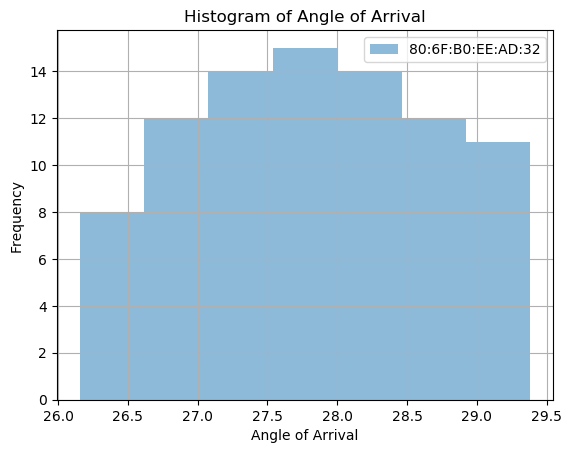

In [11]:
from lib.rtls_slave import visualize_aoa_spread

CASE = 'test99'
level = 60
visualize_aoa_spread(CASE, level)

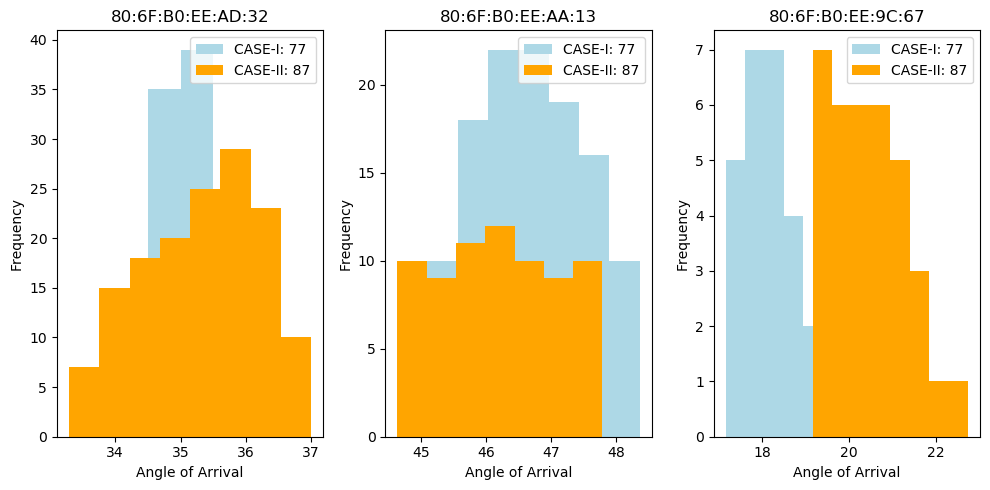

In [9]:
from lib.rtls_slave import visualize_aoa_turn_spread

CASE = 'paper'
level1 = 77
level2 = 87
vis_bias = 0

visualize_aoa_turn_spread(CASE, level1, level2, vis_bias)

### RAW DATA VISUALIZATION

In [ ]:
import matplotlib.pyplot as plt
import json

def visualize_aoa_spread(CASE, level, num_bins = 100):

    with open(f'./data/aoa_data/{CASE}_{level}.json', 'r') as f:
        aoa_data = json.load(f)

    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Set the x and y labels and title
    ax.set_xlabel("Angle of Arrival")
    ax.set_ylabel("# of Occurance")
    ax.set_title("Histogram of Angle of Arrival")

    # Set the number of bins in the histogram

    # Loop over each slave and plot its angle of arrival data as a histogram
    for slave, data in aoa_data.items():
        ax.hist(data, bins=num_bins, alpha=0.5, label=slave)

    # Add a legend to the plot
    ax.legend()

    # Show the plot
    plt.show()

    if len(aoa_data.keys())>1:
        # Set up the figure with subplots
        fig, axs = plt.subplots(nrows=1, ncols=len(aoa_data.keys()), figsize=(10, 5))

        # Iterate over each slave and plot a histogram of its angle of arrival data
        for i, slave in enumerate(aoa_data.keys()):
            axs[i].hist(aoa_data[slave], bins=num_bins,color='lightblue')  # adjust bins as needed
            axs[i].set_title(slave)
            axs[i].set_xlabel("Angle of Arrival")
            axs[i].set_ylabel("# of Occurance")

        # Adjust the spacing between subplots and display the figure
        plt.tight_layout()

        plt.show()
        
        return "SUCESS"
    

visualize_aoa_spread('one_top_indoor',70,100)